In [1]:
import sys
sys.path.append('/Users/yuch8913/miniforge3/envs/er3t_env/lib/python3.8/site-packages')
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from glob import glob
import numpy as np
from sys import exit as ext
import copy
from bisect import bisect_left
from oco_post_class_ywc import OCOSIM
from matplotlib import cm
from scipy.interpolate import interpn
from scipy import stats
from scipy.ndimage import uniform_filter
from  scipy.optimize import curve_fit
import geopy.distance
import xarray as xr
import seaborn as sns
from tool_code import *
import os, pickle 
from matplotlib import font_manager
from oco_satellite import satellite_download
import matplotlib.image as mpl_img

font_path = '/System/Library/Fonts/Supplemental/Arial.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [3]:
title_size = 16
label_size = 14
legend_size = 14
tick_size = 12

In [128]:
def cld_position(cfg_name):
    cldfile = f'../simulation/data/{cfg_name[:-4]}_{cfg_name[:8]}/pre-data.h5'
    data = {}
    with h5py.File(cldfile, 'r') as f:
        
        lon_cld = f['lon'][...]
        lat_cld = f['lat'][...]
        cth = f[f'mod/cld/logic_cld'][...]
        cld_list = cth>0

    return lon_cld, lat_cld, cld_list

In [39]:
class sat_tmp:

        def __init__(self, data):

            self.data = data
            
def grab_cfg(cfg_name):
    
    """
    Read the setting information in the assigned csv file.

    path: relative or absolute path to the setting csv file.
    """
    path = f'../simulation/cfg/{cfg_name}'
    cfg_file = pd.read_csv(path, header=None, index_col=0)
    result = {'cfg_name':path.split('/')[-1].replace('.csv', ''), 
              'cfg_path':path}
    for ind in cfg_file.index.dropna():
        contents = [str(i) for i in cfg_file.loc[ind].dropna() if str(i)[0] != '#']
        if len(contents) == 1:
            result[ind] = contents[0]
        elif len(contents) > 1:
            result[ind] = contents
    
    # check whether julian day exists and is correct
    date   = datetime.datetime(int(result['date'][:4]),    # year
                               int(result['date'][4:6]),   # month
                               int(result['date'][6:])     # day
                              )
    
    return result

In [101]:
def cld_dist_calc(cfg_name, recal=False):

    if os.path.isfile(f'{cfg_name[:-4]}_cld_distance_pdf.npy') and recal==False:
        cloud_dist = np.load(f'{cfg_name[:-4]}_cld_distance_pdf.npy')
    else:
        cldfile = f'../simulation/data/{cfg_name[:-4]}_{cfg_name[:8]}/pre-data.h5'
        data = {}
        f = h5py.File(cldfile, 'r')
        data['lon_2d'] = dict(name='Gridded longitude'               , units='degrees'    , data=f['lon'][...])
        data['lat_2d'] = dict(name='Gridded latitude'                , units='degrees'    , data=f['lat'][...])
        data['cot_2d'] = dict(name='Gridded cloud optical thickness' , units='N/A'        , data=f[f'mod/cld/cot_ipa0'][...])
        data['cer_2d'] = dict(name='Gridded cloud effective radius'  , units='micro'      , data=f[f'mod/cld/cer_ipa0'][...])
        data['cth_2d'] = dict(name='Gridded cloud top height'        , units='km'         , data=f[f'mod/cld/cth_ipa0'][...])
        f.close()


        modl1b    =  sat_tmp(data)

        lon_2d, lat_2d = modl1b.data['lon_2d']['data'], modl1b.data['lat_2d']['data']
        lon_cld, lat_cld = modl1b.data['lon_2d']['data'], modl1b.data['lat_2d']['data']
        cld_list = modl1b.data['cth_2d']['data']>0
        cld_X, cld_Y = np.where(cld_list==1)[0], np.where(cld_list==1)[1]
        cld_position = []
        for i in range(len(cld_X)):
            cld_position.append(np.array([cld_X[i], cld_Y[i]]))
        cld_position = np.array(cld_position)

        cloud_dist = np.zeros_like(lon_2d)
        for j in range(cloud_dist.shape[1]):
            for i in range(cloud_dist.shape[0]):
                if cld_list[i, j] == 1:
                    cloud_dist[i, j] = 0
                else:
                    min_ind = np.argmin(np.sqrt(np.sum((cld_position-np.array([i, j]))**2, axis=1)))
                    #print(min_ind)
                    #print(cld_position[min_ind])
                    cld_x, cld_y = cld_position[min_ind][0], cld_position[min_ind][1]
                    dist = geopy.distance.distance((lat_2d[cld_x, cld_y], lon_2d[cld_x, cld_y]), (lat_2d[i, j], lon_2d[i, j])).km
                    #print(dist)
                    cloud_dist[i, j] = dist

        np.save(f'{cfg_name[:-4]}_cld_distance_pdf.npy', cloud_dist)
    
    return cloud_dist

    #cld_slope_inter.to_pickle(f'{cfg_name[:-4]}_cld_distance_pdf.pkl')

In [134]:
# cfg_name = '20181018_central_asia_2_470cloud_test2.csv'
# cfg_name = '20161023_north_france_test.csv'
cfg_name = '20151219_north_italy_470cloud_test.csv'
# cfg_name= '20170605_amazon_470cloud.csv'
cfg_name = '20150622photon_163_225_470cloud.csv'
cfg_info = grab_cfg(cfg_name)
extent = [float(loc) for loc in cfg_info['subdomain']]
cld_lon, cld_lat, cld_location = cld_position(cfg_name)

In [135]:
cloud_dist = cld_dist_calc(cfg_name, recal=False)

In [131]:
cld_location.shape

(312, 390)

In [137]:
# mask = np.logical_and(np.logical_and(np.logical_and(cld_lon>=extent[0], cld_lon<=extent[1]), 
#                                      np.logical_and(cld_lat>=extent[2], cld_lat<=extent[3])),
#                       cloud_dist>0)
mask = cloud_dist>0

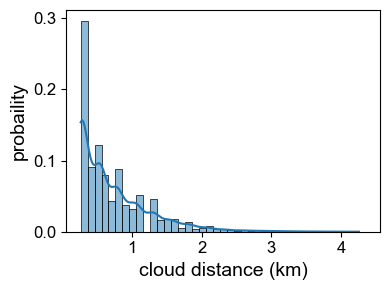

In [139]:
f, ax=plt.subplots(figsize=(4, 3))


#ax.hist(cloud_dist[mask].flatten(), bins=101, density=True, color='grey')
sns.histplot(x = cloud_dist[mask].flatten(), kde = True, stat='probability', binwidth=0.1,
             kde_kws = {'bw_adjust': 1.5},
             ax=ax)
ax.tick_params(axis='both', labelsize=tick_size)
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#plt.legend(fontsize=16, facecolor='white')
ax.set_xlabel('cloud distance (km)', fontsize=label_size)
ax.set_ylabel('probaility', fontsize=label_size)
f.tight_layout()


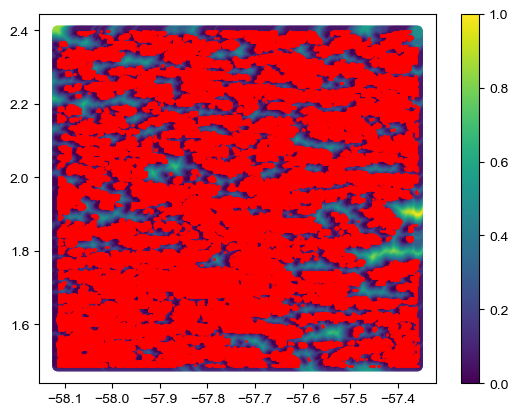

In [106]:

plt.scatter(cld_lon, cld_lat, c=cloud_dist)
plt.scatter(cld_lon[cld_location], cld_lat[cld_location], c='r', s=1)
plt.colorbar()
# plt.xlim(extent[0], extent[1])
# plt.ylim(extent[2], extent[3])

[55.15, 55.45] [33.85, 34.300000000000004]
[4.32, 4.77] [51.1, 51.660000000000004]
[11.42, 11.959999999999999] [44.6, 45.35]
[-67.19999999999999, -66.24000000000001] [0.3, 1.1]


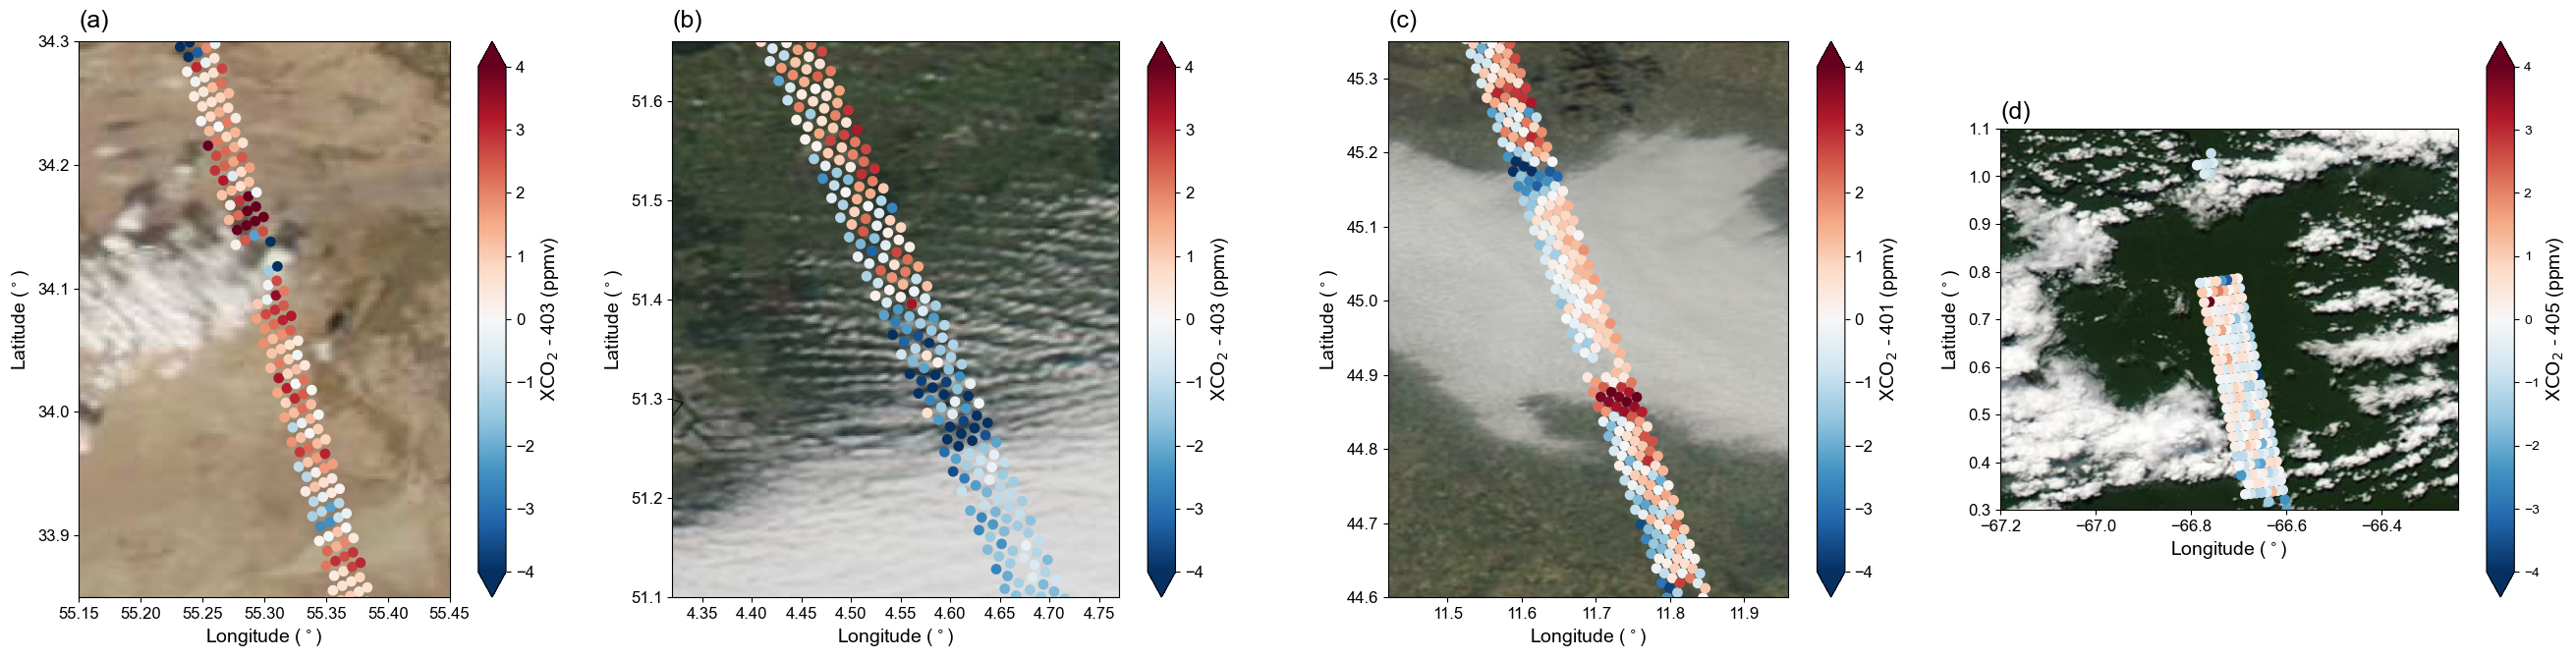

In [91]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(32*0.85, 8*0.85))


png       = ['../simulation/data/20181018_central_asia_2_470cloud_20181018/aqua_rgb_2018-10-18_55.00-55.60-33.70-34.45.png',
         [55.00, 55.60, 33.70, 34.45]]
img = png[0]
wesn= png[1]
with open(f'20181018_central_asia_2_470cloud_test2_o2a.pkl', 'rb') as file:
    o_ax1 = pickle.load(file)

img = mpimg.imread(img)
ax1.imshow(img, extent=wesn)
lon_dom = [wesn[0]+0.15, wesn[1]-0.15]
lat_dom = [wesn[2]+0.15, wesn[3]-0.15]
ax1.set_xlim(np.min(lon_dom), np.max(lon_dom))
ax1.set_ylim(np.min(lat_dom), np.max(lat_dom))
print(lon_dom, lat_dom)

c1 = ax1.scatter(o_ax1.lon, o_ax1.lat, 
               c=getattr(o_ax1, 'co2')*1e6-403, s=45,
               cmap='RdBu_r', vmin=-4, vmax=4)

cbar1 = f.colorbar(c1, ax=ax1, extend='both')
cbar1.set_label('$\mathrm{XCO_2}$ - 403 (ppmv)', fontsize=label_size)


png       = ['../simulation/data/20161023_north_france_test_20161023/aqua_rgb_2016-10-23_4.17-4.92-50.95-51.81.png',
         [4.17, 4.92, 50.95, 51.81]]
img = png[0]
wesn= png[1]
with open(f'20161023_north_france_test_o2a.pkl', 'rb') as file:
    o_ax2 = pickle.load(file)
    
img = mpimg.imread(img)
ax2.imshow(img, extent=wesn)
lon_dom = [wesn[0]+0.15, wesn[1]-0.15]
lat_dom = [wesn[2]+0.15, wesn[3]-0.15]
print(lon_dom, lat_dom)
ax2.set_xlim(np.min(lon_dom), np.max(lon_dom))
ax2.set_ylim(np.min(lat_dom), np.max(lat_dom))

c2 = ax2.scatter(o_ax2.lon, o_ax2.lat, 
               c=getattr(o_ax2, 'co2')*1e6-403, s=45,
               cmap='RdBu_r', vmin=-4, vmax=4)

cbar2 = f.colorbar(c2, ax=ax2, extend='both')
cbar2.set_label('$\mathrm{XCO_2}$ - 403 (ppmv)', fontsize=label_size)

    
    
png       = ['../simulation/data/20151219_north_italy_470cloud_test_20151219/aqua_rgb_2015-12-19_11.27-12.11-44.45-45.50.png',
         [11.27, 12.11, 44.45, 45.50]]
img = png[0]
wesn= png[1]
with open(f'20151219_north_italy_470cloud_test_o2a.pkl', 'rb') as file:
    o_ax3 = pickle.load(file)
with xr.open_dataset(f'../simulation/data/oco/oco2_LtCO2_151219_B10206Ar_200730213244s.nc4') as file:
    qf = file['xco2_quality_flag']
    snd = file['sounding_id']
qf_array = np.empty_like(getattr(o_ax3, 'co2'))
qf_array[...] = np.nan
for i in range(qf_array.shape[0]):
    for j in range(qf_array.shape[1]):
        ind = np.where(snd == o_ax3.snd[i, j])[0]

        if len(ind)>0:
            qf_array[i, j] = qf[ind]
img = mpimg.imread(img)
ax3.imshow(img, extent=wesn)
lon_dom = [wesn[0]+0.15, wesn[1]-0.15]
lat_dom = [wesn[2]+0.15, wesn[3]-0.15]
print(lon_dom, lat_dom)
ax3.set_xlim(np.min(lon_dom), np.max(lon_dom))
ax3.set_ylim(np.min(lat_dom), np.max(lat_dom))
mask = ~np.isnan(qf_array)
#mask = qf_array==1
c3 = ax3.scatter(o_ax3.lon[mask], o_ax3.lat[mask], 
               c=getattr(o_ax3, 'co2')[mask]*1e6-401, s=45,
               cmap='RdBu_r', vmin=-4, vmax=4)

cbar3 = f.colorbar(c3, ax=ax3, extend='both')
cbar3.set_label('$\mathrm{XCO_2}$ - 401 (ppmv)', fontsize=label_size)


png       = ['../simulation/data/20170605_amazon_470cloud_20170605/aqua_rgb_2017-06-05_-67.35--66.09--0.15-1.25.png',
         [-67.35, -66.09, 0.15, 1.25]]
img = png[0]
wesn= png[1]
with open(f'20170605_amazon_470cloud_o2a.pkl', 'rb') as file:
    o_ax4 = pickle.load(file)
with xr.open_dataset(f'../simulation/data/oco/oco2_LtCO2_170605_B10206Ar_200730080146s.nc4') as file:
    qf = file['xco2_quality_flag']
    snd = file['sounding_id']
qf_array = np.empty_like(getattr(o_ax4, 'co2'))

qf_array[...] = np.nan
for i in range(qf_array.shape[0]):
    for j in range(qf_array.shape[1]):
        ind = np.where(snd == o_ax4.snd[i, j])[0]
        if len(ind)>0:
            qf_array[i, j] = qf[ind]

img = mpimg.imread(img)
ax4.imshow(img, extent=wesn)
lon_dom = [wesn[0]+0.15, wesn[1]-0.15]
lat_dom = [wesn[2]+0.15, wesn[3]-0.15]
print(lon_dom, lat_dom)
ax4.set_xlim(np.min(lon_dom), np.max(lon_dom))
ax4.set_ylim(np.min(lat_dom), np.max(lat_dom))
mask = ~np.isnan(qf_array)
#mask = qf_array==1
c4 = ax4.scatter(o_ax4.lon[mask], o_ax4.lat[mask], 
               c=getattr(o_ax4, 'co2')[mask]*1e6-405, s=45,
               cmap='RdBu_r', vmin=-4, vmax=4)

cbar4 = f.colorbar(c4, ax=ax4, extend='both')
cbar4.set_label('$\mathrm{XCO_2}$ - 405 (ppmv)', fontsize=label_size)


for i in range(4):
    ax = [ax1, ax2, ax3, ax4][i]
    fig_label = ['(a)', '(b)', '(c)', '(d)'][i]
    ax.tick_params(axis='both', labelsize=tick_size)
    ax.set_xlabel('Longitude ($^\circ$)', fontsize=label_size)
    ax.set_ylabel('Latitude ($^\circ$)', fontsize=label_size)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.text(xmin+0.0*(xmax-xmin), ymin+1.025*(ymax-ymin), fig_label, fontsize=label_size+4, color='k')

for cbar in [cbar1, cbar2, cbar3]:
    cbar.ax.tick_params(labelsize=tick_size)


f.tight_layout()
f.savefig('MODIS_OCO_cloud_effect_example.png', dpi=300)

In [85]:
print(o_ax3.snd)

[[2015121912155801 2015121912155802 2015121912155803 2015121912155804
  2015121912155805 2015121912155806 2015121912155807 2015121912155808]
 [2015121912155831 2015121912155832 2015121912155833 2015121912155834
  2015121912155835 2015121912155836 2015121912155837 2015121912155838]
 [2015121912155871 2015121912155872 2015121912155873 2015121912155874
  2015121912155875 2015121912155876 2015121912155877 2015121912155878]
 [2015121912155901 2015121912155902 2015121912155903 2015121912155904
  2015121912155905 2015121912155906 2015121912155907 2015121912155908]
 [2015121912155931 2015121912155932 2015121912155933 2015121912155934
  2015121912155935 2015121912155936 2015121912155937 2015121912155938]
 [2015121912155971 2015121912155972 2015121912155973 2015121912155974
  2015121912155975 2015121912155976 2015121912155977 2015121912155978]
 [2015121912160001 2015121912160002 2015121912160003 2015121912160004
  2015121912160005 2015121912160006 2015121912160007 2015121912160008]
 [20151219121